<a href="https://colab.research.google.com/github/aet-lang/Contract-Awards-in-Investment-Project-Financing/blob/main/Contract_Awards_in_Investment_Project_Financing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import all necessary libraries

In [37]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tabulate import tabulate

## Load the dataset

In [38]:
url = "https://drive.google.com/file/d/1496FirGMyjno5F8mPWglW5tY5GRXgI5a/view?usp=drive_link"
file_id = url.split('/')[-2]
dwn_url = f"https://drive.google.com/uc?id={file_id}"
df = pd.read_csv(dwn_url)

## Dataset information

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14350 entries, 0 to 14349
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   As of Date                          14350 non-null  object 
 1   Fiscal Year                         14350 non-null  int64  
 2   Region                              14350 non-null  object 
 3   Borrower Country / Economy          14350 non-null  object 
 4   Borrower Country / Economy Code     14165 non-null  object 
 5   Project ID                          14350 non-null  object 
 6   Project Name                        14350 non-null  object 
 7   Project Global Practice             12443 non-null  object 
 8   Procurement Category                14350 non-null  object 
 9   Procurement Method                  14350 non-null  object 
 10  WB Contract Number                  14350 non-null  int64  
 11  Contract Description                14349

# Data Preprocessing

**Drop duplicates**

In [41]:
df.drop_duplicates(inplace=True)

**Convert date columns**

In [42]:
for date_col in ["Signing Date", "As of Date"]:
    if date_col in df.columns:
        df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
        df[f"{date_col}_Year"] = df[date_col].dt.year
        df[f"{date_col}_Month"] = df[date_col].dt.month
        df[f"{date_col}_Quarter"] = df[date_col].dt.quarter

**Fill missing (mode for object, median for numeric)**

In [43]:
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        df[col] = df[col].fillna(df[col].median())

**Visualize missing data**

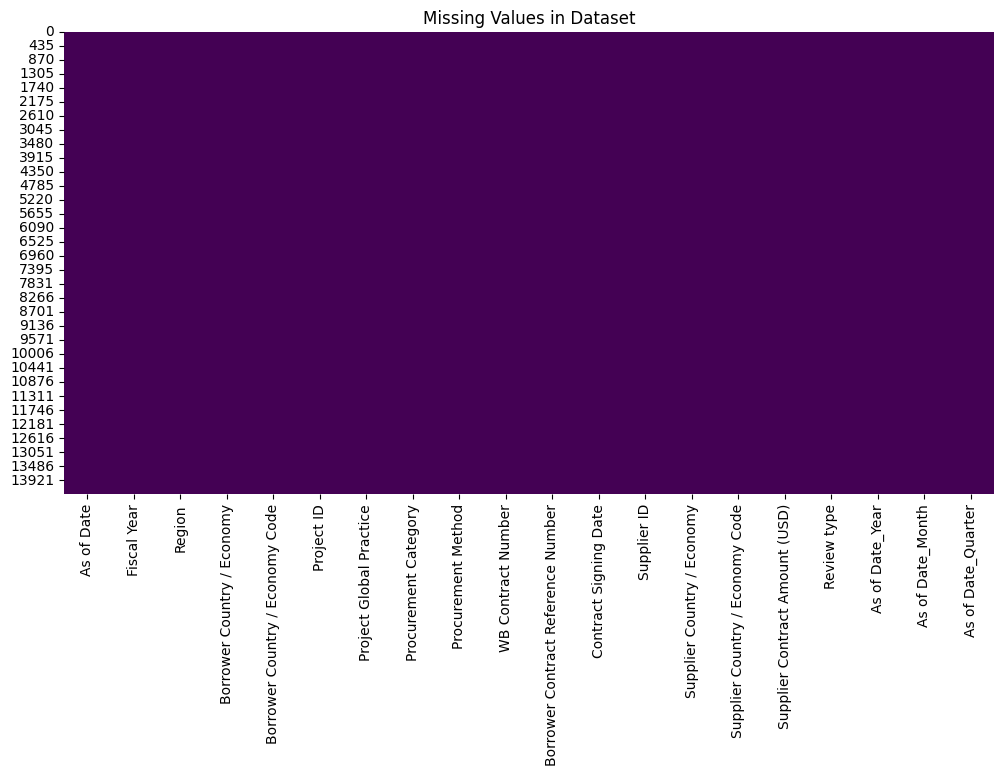

In [44]:
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values in Dataset")
plt.show()

**Target Column Check**

In [45]:
target_col = "Supplier Contract Amount (USD)"
X = df.drop(columns=[target_col])
y = df[target_col]

**Boxplot of target**

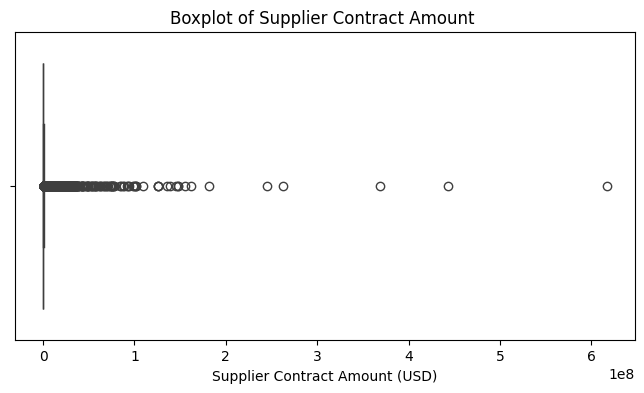

In [46]:
plt.figure(figsize=(8,4))
sns.boxplot(x=df["Supplier Contract Amount (USD)"])
plt.title("Boxplot of Supplier Contract Amount ")
plt.show()

# Feauture Engineering

**Encode Categorical Columns**

In [47]:
cat_cols = X.select_dtypes(include=["object"]).columns
encoder = TargetEncoder(cols=cat_cols)
X_encoded = encoder.fit_transform(X, y)

**Define Features**

In [50]:
# keep only numeric columns
X_numeric = X.select_dtypes(include=['int64', 'float64'])

# scale them
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)


**Feature Scaling**

In [51]:
X = df.drop(columns=[target_col])

# Drop datetime columns
for col in X.select_dtypes(include=['datetime64', 'datetime64[ns]']):
    X[col] = X[col].astype('int64')
cat_cols = X.select_dtypes(include=['object']).columns
encoder = TargetEncoder(cols=cat_cols)
X_encoded = encoder.fit_transform(X, y)
y = df[target_col]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)


**Train-Test Split**

In [52]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42)

# Modelling

**Evaluation Function**

In [53]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"\\n📊 {name} Results:")
    print(f"  - MAE: {mae:.2f}")
    print(f"  - MSE: {mse:.2f}")
    print(f"  - R² Score: {r2:.4f}")

    plt.figure(figsize=(7, 5))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{name} - Actual vs Predicted")
    plt.grid(True)
    plt.show()

    residuals = y_test - y_pred
    plt.figure(figsize=(7, 4))
    sns.histplot(residuals, bins=30, kde=True)
    plt.title(f"{name} - Residuals Distribution")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    return {'name': name, 'mae': mae, 'mse': mse, 'r2': r2, 'y_pred': y_pred}


**Define smaller subsets for faster testing**

In [55]:
X_train_small = X_train[:1000]
y_train_small = y_train[:1000]

X_test_small = X_test[:200]
y_test_small = y_test[:200]

**Evaluate Linear Regression and Random Forest**

\n📊 Linear Regression Results:
  - MAE: 307802.01
  - MSE: 883074418225.11
  - R² Score: 0.9757


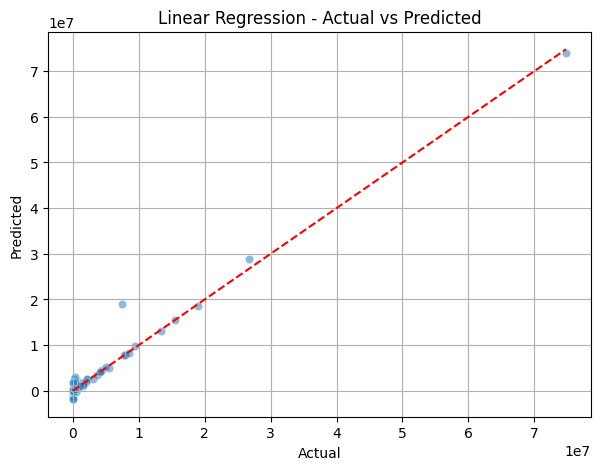

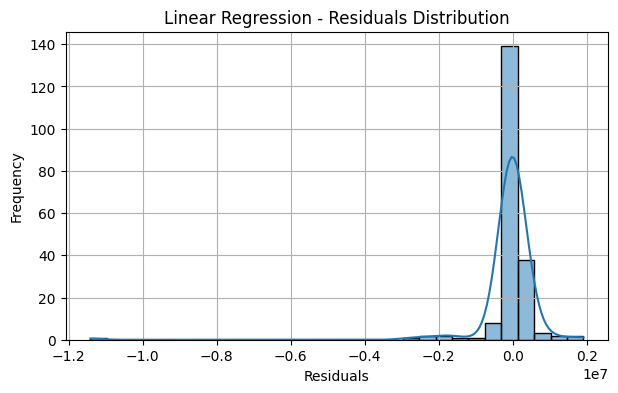

\n📊 Random Forest Results:
  - MAE: 355151.96
  - MSE: 3525353662682.52
  - R² Score: 0.9029


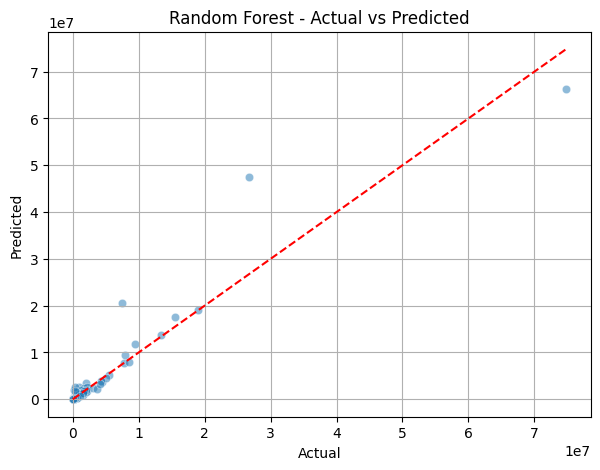

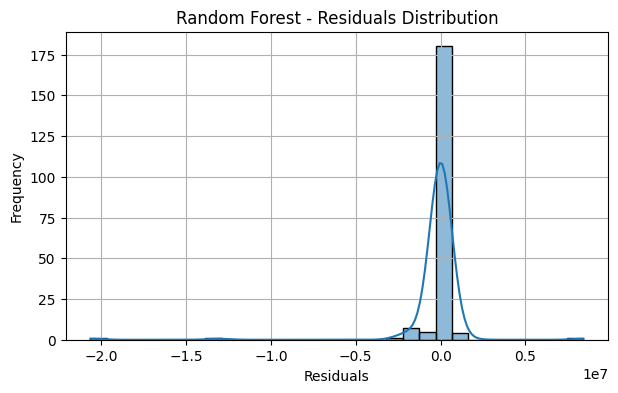

In [56]:
r_result = evaluate_model("Linear Regression", LinearRegression(), X_train_small, y_train_small, X_test_small, y_test_small)
rf_result = evaluate_model("Random Forest", RandomForestRegressor(n_estimators=20, random_state=42), X_train_small, y_train_small, X_test_small, y_test_small)


**Cross-validation scores**


In [57]:
def cross_validate_model(model, name):
    scores = cross_val_score(model, X_scaled, y, scoring='r2', cv=10)
    print(f"{name} Cross-Validation R² Scores:\\n", scores)
    print(f"Mean R²: {scores.mean():.4f}, Std: {scores.std():.4f}\\n")

cross_validate_model(LinearRegression(), "Linear Regression")
cross_validate_model(RandomForestRegressor(n_estimators=20, random_state=42), "Random Forest")

Linear Regression Cross-Validation R² Scores:\n [0.99688344 0.93910387 0.99618112 0.96722192 0.9892884  0.97466225
 0.99886966 0.75498625 0.98511177 0.96238481]
Mean R²: 0.9565, Std: 0.0695\n
Random Forest Cross-Validation R² Scores:\n [0.97162617 0.94061868 0.86442813 0.97295059 0.99306019 0.95404374
 0.98358742 0.93894809 0.96072025 0.98164211]
Mean R²: 0.9562, Std: 0.0350\n


**Learning Curves**

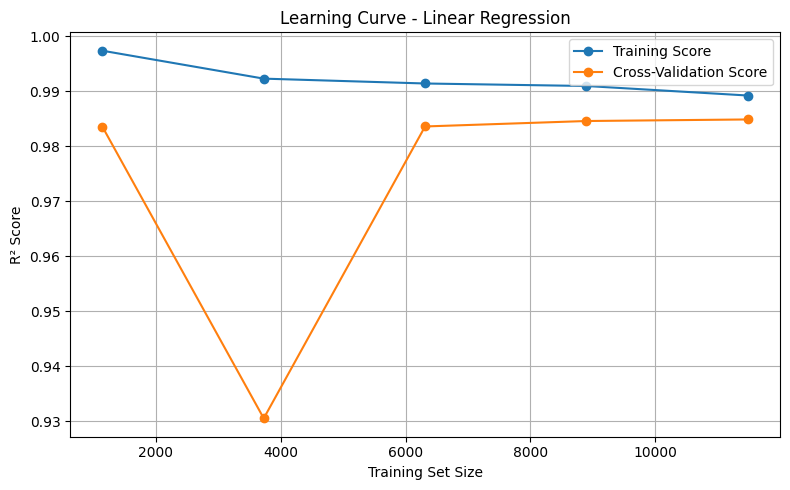

In [58]:
def plot_learning_curve(estimator, title):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator,
        X_scaled, y,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5)
    )

    train_mean = train_scores.mean(axis=1)
    test_mean = test_scores.mean(axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_mean, label='Training Score', marker='o')
    plt.plot(train_sizes, test_mean, label='Cross-Validation Score', marker='o')
    plt.title(f"Learning Curve - {title}")
    plt.xlabel("Training Set Size")
    plt.ylabel("R² Score")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_learning_curve(LinearRegression(), "Linear Regression")

**GridSearchCV on Random Forest**

In [59]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
grid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='r2')
grid.fit(X_train, y_train)

print(" Best RF Parameters:", grid.best_params_)
print("Best R² Score:", grid.best_score_)

 Best RF Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Best R² Score: 0.9015936980819816


**Feature Importance**

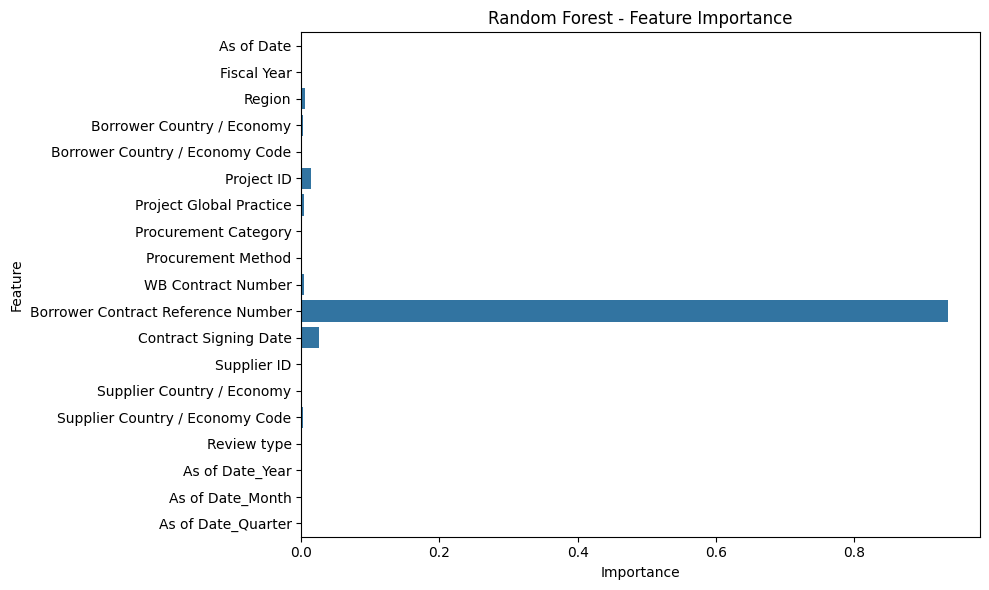

In [60]:
best_rf = grid.best_estimator_
feat_imp = best_rf.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp, y=features)
plt.title("Random Forest - Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

**Residuals vs Fitted for best RF**

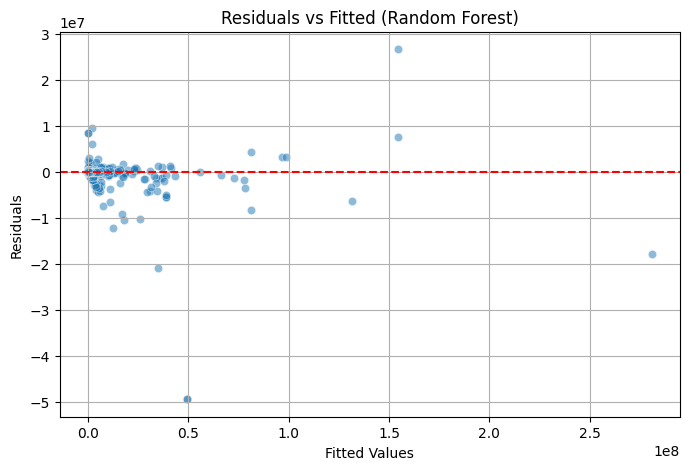

In [61]:
y_pred_rf = best_rf.predict(X_test)
residuals = y_test - y_pred_rf

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred_rf, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Fitted (Random Forest)")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

# Results

In [62]:
y_pred_rf = rf_result['y_pred']

results = [
    ["Linear Regression", r_result['mae'], r_result['mse'], r_result['r2']],
    ["Random Forest", rf_result['mae'], rf_result['mse'], rf_result['r2']],
    ["Tuned Random Forest",
     mean_absolute_error(y_test_small, y_pred_rf),
     mean_squared_error(y_test_small, y_pred_rf),
     r2_score(y_test_small, y_pred_rf)]
]

headers = ["Model", "MAE", "MSE", "R²"]

print("\n Final Model Comparison:")
print(tabulate(results, headers=headers, floatfmt=".2f"))



 Final Model Comparison:
Model                      MAE               MSE    R²
-------------------  ---------  ----------------  ----
Linear Regression    307802.01   883074418225.11  0.98
Random Forest        355151.96  3525353662682.52  0.90
Tuned Random Forest  355151.96  3525353662682.52  0.90
